# **Exercise 4: Restricted Boltzmann Machines (RMB)**

Group 2406:
- Cavezza Lorenzo
- Doda Giulia
- Longaroni Giacomo
- Ravagnani Laura

We want to study the performances of an RMB, and, by looking at its learned weights and biases, better understand the correlations in the data ($N=10^4$ with $L=10$ bits). We use an RBM with $M=3$ hidden units.

In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

### Data

In [2]:
dname="DATA"; fname=dname+'/x_RBM_2024_lesson.dat'

# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1]) # total visible units
print('Total visible units:', L)

#SPINS = True
SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2 # energy gap
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
print('...')

Total visible units: 12
each of N=10000 data has L=12 digits
[0 0 1 1 0 0 1 0 0 0 1 1]
[0 0 1 1 0 0 0 1 0 0 0 0]
[1 1 0 0 1 0 0 0 0 1 0 0]
[0 0 1 1 0 1 1 1 1 0 0 0]
[1 0 1 0 1 1 1 1 1 1 0 0]
[0 0 1 0 1 1 0 0 1 1 0 0]
[1 1 1 0 0 0 1 1 0 1 1 1]
[1 1 1 1 0 0 1 0 1 1 0 0]
[1 1 0 0 0 0 1 1 0 0 1 1]
[1 1 1 0 1 1 0 0 1 0 0 0]
[0 0 0 1 0 1 0 0 0 0 1 1]
[1 1 1 1 1 1 0 1 1 1 0 0]
...


In [4]:
from IPython.display import display_html 
import pandas as pd

def is_one(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: white;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

N1=12
df0 = pd.DataFrame(v[:N1])
df0s = df0.style.set_table_attributes("style='display:inline'")
df0s.applymap(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)

display_html(df0s._repr_html_(), raw=True)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,1,1,0,0,1,0,0,0,1,1
1,0,0,1,1,0,0,0,1,0,0,0,0
2,1,1,0,0,1,0,0,0,0,1,0,0
3,0,0,1,1,0,1,1,1,1,0,0,0
4,1,0,1,0,1,1,1,1,1,1,0,0
5,0,0,1,0,1,1,0,0,1,1,0,0
6,1,1,1,0,0,0,1,1,0,1,1,1
7,1,1,1,1,0,0,1,0,1,1,0,0
8,1,1,0,0,0,0,1,1,0,0,1,1
9,1,1,1,0,1,1,0,0,1,0,0,0


We could see some local structures.

## Initialize

In [5]:
# RBM, nr of hidden units
M = 3
# range of each initial weight
sigma = sqrt(4. / float(L + M)) # std dev of the initial weights in the layers
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M) # interaction matrix
a = sigma * np.random.randn(L) 
b = np.zeros(M)
print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

w= [[-1.05710581e-01  2.47325276e-01 -2.68236999e-01]
 [-2.86977895e-01  1.01512472e+00  7.19551678e-01]
 [ 4.79774212e-02  1.45493088e-01  3.97121546e-01]
 [ 6.43656130e-01  5.20110348e-01 -6.69365702e-01]
 [ 1.42005069e-01  1.18210102e-01  6.98643250e-01]
 [ 4.57750143e-01 -1.03364106e+00 -1.92018661e-01]
 [ 8.61880964e-01 -2.26476438e-01 -2.78721284e-01]
 [ 2.46314000e-01  1.67774743e+00 -5.27359626e-01]
 [-2.98006602e-01  6.40959511e-02  1.56268971e-01]
 [ 2.70474733e-01  4.85557355e-04  6.93940393e-01]
 [-3.68472529e-01 -4.29205842e-01 -1.22398236e+00]
 [-9.60892739e-01 -4.44493209e-01  2.89257786e-01]]
a= [-0.65372576  0.06187846 -0.54919547  0.1718999  -1.21839863 -0.10304354
 -0.79628307 -0.50128587 -0.67494752  0.14787037  0.19519016 -0.38930533]
b= [0. 0. 0.]


## Plotting

To have some visual interpretation.

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1]


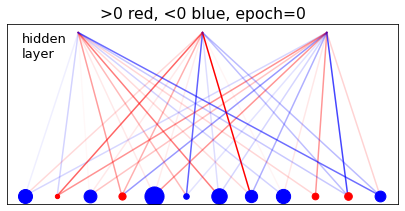

In [6]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)

(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0, w=w, a=a, b=b, CD=0):
    fig, ax = plt.subplots(1,1 , figsize=(7, 3.3))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=300.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")

    if CD == 0:
        ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    else:
        ax.set_title(f'>0 red, <0 blue, epoch={epoch}, CD={CD}')
    ax.text(-0.51,0.85,"hidden\nlayer")
    plt.show()
                  
plotgraph()

Transparency is associated to the strenght of the weights.

### Activation function with sigmoid


In [7]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False): # v_in could be also the hidden one, info=True to print out something
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input =', v_in)
        print('act =',act)
        print('prob =',prob) # probabilities to have a 1 in the hidden units (before training)
        print('output =',v_out)
    return v_out

k = 0
print('input shape', v[k].shape)
print('weight matrix shape:', w.shape)
activate(v[k],w,b,GAP,info=True) # the output is an array of hidden units activated according to probabilities

input shape (12,)
weight matrix shape: (12, 3)
input = [0 0 1 1 0 0 1 0 0 0 1 1]
act = [ 0.22414925 -0.43457205 -1.48569002]
prob = [0.55580386 0.3930351  0.18456951]
output = [0 0 0]


array([0, 0, 0])

## RBM train


In [8]:
# random seed for reproducibility
np.random.seed(12345)

# contrastive divergence
CD_n = True
CD_n_steps = 1

# training function
def RBM_train(weights = w, a_func = a, b_func = b, verbose=False):

    # visualize initialized RBM
    if verbose:
        plotgraph(0)

    # learning rate
    l_rate = 1.0

    # minibatch, counter m that ranges from 0 to 500
    mini, m = 500, 0

    for epoch in range(100):
        # aggregate normalization of batch statistics and learning rate in l_rate_m
        l_rate_m = l_rate / mini
        for k in range(N): # running over the full dataset
            if m==0: # start of the minibatch
                # initialize averages in miniblock
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data, vh_model= np.zeros((L,M)), np.zeros((L,M))

            # positive CD phase: generating h 
            h = activate(v[k],weights,b_func,GAP)
            # negative CD phase: generating fantasy vf
            vf = activate(h,weights.T,a_func,GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf,weights,b_func,GAP)

            # contrastive divergence steps
            if CD_n:
                step = CD_n_steps - 1
                while step > 0:
                    vf = activate(hf,weights.T,a_func,GAP)
                    hf = activate(vf,weights,b_func,GAP)
                    step = step - 1

            # updating sum variables
            v_data  += v[k]
            v_model += vf
            h_data  += h
            h_model += hf
            vh_data += np.outer(v[k].T,h)
            vh_model+= np.outer(vf.T,hf)
        
            # updating minibatch internal counter
            m += 1

            # minibatch end
            if m==mini:
                # gradient of the likelihood: follow it along its positive direction
                # with a "vanilla" SGD
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)
                if epoch<=1 and k<=mini:
                    if verbose:
                        print('----------- epoch =',epoch,'  k =',k,'  m =',m)
                        print('dw =',dw)
                        print('da =',da)
                        print('db =',db)
                # basic step of vanilla gradient descent, from eq.(211)
                weights = weights + dw
                a_func = a_func + da
                b_func = b_func + db
                m=0
        
        # calculate likelihood
        

        # randomize the order of input data at each epoch
        np.random.shuffle(v)
        # decrease the learning rate (here as a power law)
        l_rate = l_rate / (0.01 * l_rate + 1)
        if epoch%10==9:
            if verbose:
                plotgraph(epoch+1, w=weights, a=a_func, b=b_func)
                print('l_rate = ',l_rate)

    return (weights, a_func, b_func)

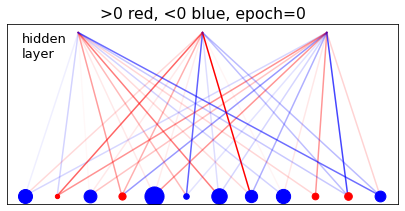

----------- epoch = 0   k = 499   m = 500
dw = [[ 0.06   0.078  0.054]
 [-0.182 -0.24  -0.148]
 [ 0.024  0.002  0.018]
 [-0.084 -0.126 -0.094]
 [ 0.06   0.046  0.054]
 [ 0.05   0.054  0.062]
 [ 0.064  0.08   0.032]
 [-0.08  -0.118 -0.092]
 [ 0.1    0.108  0.066]
 [-0.118 -0.144 -0.11 ]
 [ 0.138  0.13   0.086]
 [ 0.106  0.1    0.058]]
da = [ 0.162 -0.226  0.074 -0.12   0.142  0.162  0.13  -0.088  0.174 -0.18
  0.234  0.208]
db = [-0.046 -0.086 -0.064]
----------- epoch = 1   k = 499   m = 500
dw = [[-0.05742574 -0.0019802   0.00792079]
 [-0.03168317  0.0039604  -0.00792079]
 [-0.03564356 -0.04554455 -0.03564356]
 [-0.02178218 -0.02970297 -0.00594059]
 [-0.03960396 -0.02970297  0.04554455]
 [-0.03762376 -0.05346535  0.03168317]
 [-0.01782178  0.04356436 -0.01188119]
 [-0.04158416 -0.03564356 -0.02178218]
 [-0.02772277 -0.00594059  0.05148515]
 [-0.03960396 -0.02178218 -0.02772277]
 [-0.03762376  0.0019802   0.02772277]
 [-0.02178218  0.0039604  -0.01584158]]
da = [-0.00594059  0.        

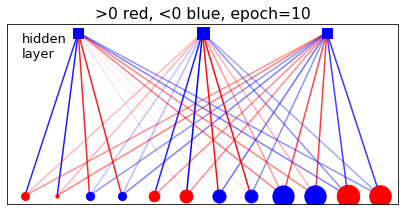

l_rate =  0.9090909090909092


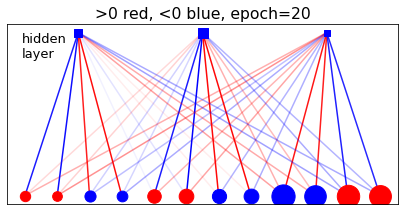

l_rate =  0.8333333333333337


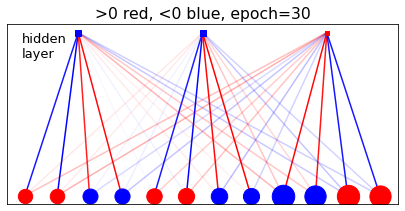

l_rate =  0.7692307692307697


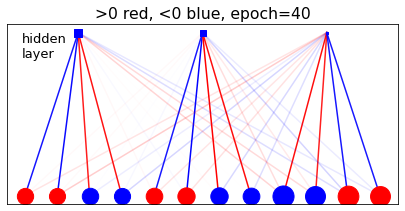

l_rate =  0.7142857142857149


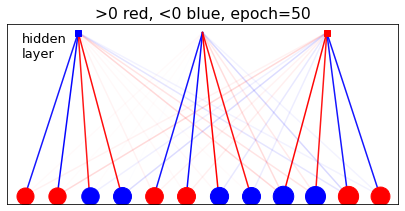

l_rate =  0.6666666666666671


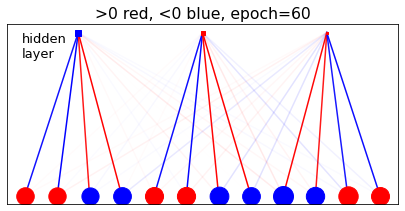

l_rate =  0.6250000000000006


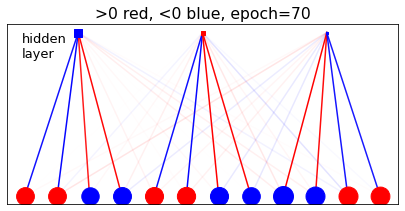

l_rate =  0.5882352941176475


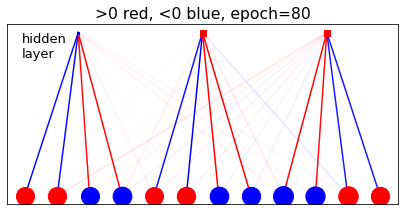

l_rate =  0.555555555555556


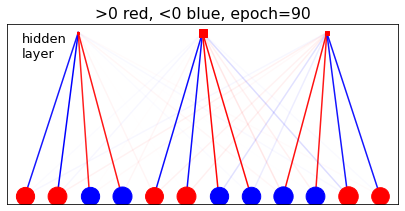

l_rate =  0.5263157894736847


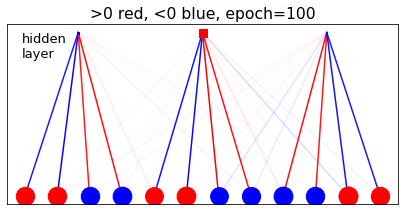

l_rate =  0.5000000000000009


In [9]:
training_results = RBM_train(verbose=True)

The colors tells us the kind of correlation between inputs. We impose a stochastic structure in visible layer through hidden variables. 

In [10]:
print('Initial weights:')
print('w0 =',w0);print('a0 =',a0);print('b0 =',b0)
print('\nFinal weights:')
print('w =',training_results[0]);print('a =',training_results[1]);print('b =',training_results[2])

Initial weights:
w0 = [[-1.05710581e-01  2.47325276e-01 -2.68236999e-01]
 [-2.86977895e-01  1.01512472e+00  7.19551678e-01]
 [ 4.79774212e-02  1.45493088e-01  3.97121546e-01]
 [ 6.43656130e-01  5.20110348e-01 -6.69365702e-01]
 [ 1.42005069e-01  1.18210102e-01  6.98643250e-01]
 [ 4.57750143e-01 -1.03364106e+00 -1.92018661e-01]
 [ 8.61880964e-01 -2.26476438e-01 -2.78721284e-01]
 [ 2.46314000e-01  1.67774743e+00 -5.27359626e-01]
 [-2.98006602e-01  6.40959511e-02  1.56268971e-01]
 [ 2.70474733e-01  4.85557355e-04  6.93940393e-01]
 [-3.68472529e-01 -4.29205842e-01 -1.22398236e+00]
 [-9.60892739e-01 -4.44493209e-01  2.89257786e-01]]
a0 = [-0.65372576  0.06187846 -0.54919547  0.1718999  -1.21839863 -0.10304354
 -0.79628307 -0.50128587 -0.67494752  0.14787037  0.19519016 -0.38930533]
b0 = [0. 0. 0.]

Final weights:
w = [[-2.11980205  0.00338158  0.02344499]
 [-2.32773063 -0.06990947  0.08920206]
 [ 2.10520438  0.00951075  0.0940959 ]
 [ 2.25517085  0.07869226 -0.0409069 ]
 [ 0.18395678 -2.1960

## Test: noise reduction

In [12]:
ampl=40.

# original, non-reshuffled data in v0
v1 = np.zeros_like(v0)
for k in range(N):
    # positive CD phase: generating h 
    h = activate(v0[k],training_results[0],training_results[2],ampl*GAP)
    # negative CD phase: generating fantasy vf with low T == large GAP
    v1[k] = activate(h,training_results[0].T,training_results[1],ampl*GAP)
    
# difference between fantasy and data
minib_size = 500
diff = (v1 - v0)/2
str0 = fname+'_M'+str(M)+'-mini'+str(minib_size)
np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')  

N1=12
df0 = pd.DataFrame(v0[:N1])
df1 = pd.DataFrame(((v1[:N1]-vmin)/(1-vmin)).astype(int))

df0s = df0.style.set_table_attributes("style='display:inline'")
df1s = df1.style.set_table_attributes("style='display:inline'")
df0s.applymap(is_one)
df1s.applymap(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)
df1s.set_caption('Low Temperature').set_table_styles(sty)

display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,1,1,0,0,1,0,0,0,1,1
1,0,0,1,1,0,0,0,1,0,0,0,0
2,1,1,0,0,1,0,0,0,0,1,0,0
3,0,0,1,1,0,1,1,1,1,0,0,0
4,1,0,1,0,1,1,1,1,1,1,0,0
5,0,0,1,0,1,1,0,0,1,1,0,0
6,1,1,1,0,0,0,1,1,0,1,1,1
7,1,1,1,1,0,0,1,0,1,1,0,0
8,1,1,0,0,0,0,1,1,0,0,1,1
9,1,1,1,0,1,1,0,0,1,0,0,0


Low temperature: the sigmoid becomes like a step function and the patterns become clearer.

### 1. Increase the number of CD (contrastive divergence) step from $n=1$ to $n=5$.

In [13]:
for i in range(1,6):
    w_CD, a_CD, b_CD = RBM_train()
    plotgraph(epoch=100, w=w_CD, a=a_CD, b=b_CD, CD=i)

KeyboardInterrupt: 

### 2. Compute the log-likelihood during the training, at every epoch, or every minibatch update if it reaches a maximum already in the first epoch. Use 't' as an index of this 'time', indicating the unit in the figures.

To compute the likelihood, consider full configurations $x = (v,h)$ and their energy $E(x)$. With $L$ visible units and $M$ hidden units, we have $2^{L+M}$ possible configurations. 

The **partition function $Z$** is the sum of all the Boltzmann weights $e^{-E(x)}$ of all the possible configurations. 

The **average expectation of the energy according to data** is computed by averaging the energy of each data sample $v_n$ completed with all $2^M$ possible hidden states. Thus, in total there are $N*2^M$ configurations to use in the $<E>_{data}$ average.

In [14]:
import itertools as it

# get all the possible configurations
def get_config(Q):
    conf = it.product((0,1), repeat=Q)
    conf = list(conf)
    return np.array(conf)

In [15]:
# all configurations between visible and hidden variables
all_conf = get_config(L+M)

# alla configurations of hidden variables
all_conf_hid = get_config(M)

In [16]:
# useful functions to compute the likelihood

# energy average
def energy(vis,hid,weights,a_func,b_func):
    return (-np.dot(a_func, vis) - np.dot(b_func, hid) - np.dot(np.dot(vis, weights),hid))

# partition function Z
def part_func_Z(weights, a_func, b_func):
    boltz_w = []
    for c in all_conf:
        v = c[:L]
        h = c[L:]
        boltz_w.append(np.exp(- energy(v, h, weights, a_func, b_func)))
    return np.sum(np.array(boltz_w))

# average expectation of the energy according to data
def av_energy_data(vk, weights, a_func, b_func):
    e = []
    for c in all_conf_hid:
        e.append(energy(vk, c, weights, a_func, b_func))
    return np.sum(np.array(e))/(2**M)

In [31]:
def RBM_train_L(weights = w, a_func = a, b_func = b, verbose=False):

    # visualize initialized RBM
    if verbose:
        plotgraph(0)

    # learning rate
    l_rate = 1.0

    # minibatch, counter m that ranges from 0 to 500
    mini, m = 500, 0

    # likelihood over epochs
    lik = []
    data_energies = []
    logZs = []

    for epoch in range(150):
        # aggregate normalization of batch statistics and learning rate in l_rate_m
        l_rate_m = l_rate / mini
        energies = []
        for k in range(N): # running over the full dataset
            if m==0: # start of the minibatch
                # initialize averages in miniblock
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data, vh_model= np.zeros((L,M)), np.zeros((L,M))

            # positive CD phase: generating h 
            h = activate(v[k],weights,b_func,GAP)
            # negative CD phase: generating fantasy vf
            vf = activate(h,weights.T,a_func,GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf,weights,b_func,GAP)

            # contrastive divergence steps
            if CD_n:
                step = CD_n_steps - 1
                while step > 0:
                    vf = activate(hf,weights.T,a_func,GAP)
                    hf = activate(vf,weights,b_func,GAP)
                    step = step - 1

            # updating sum variables
            v_data  += v[k]
            v_model += vf
            h_data  += h
            h_model += hf
            vh_data += np.outer(v[k].T,h)
            vh_model+= np.outer(vf.T,hf)
        
            # updating minibatch internal counter
            m += 1

            # minibatch end
            if m==mini:
                # gradient of the likelihood: follow it along its positive direction
                # with a "vanilla" SGD
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)
                if epoch<=1 and k<=mini:
                    if verbose:
                        print('----------- epoch =',epoch,'  k =',k,'  m =',m)
                        print('dw =',dw)
                        print('da =',da)
                        print('db =',db)
                # basic step of vanilla gradient descent, from eq.(211)
                weights = weights + dw
                a_func = a_func + da
                b_func = b_func + db
                m=0

            #ek = av_energy_data(v[k], weights, a_func, b_func)
            #energies.append(ek)
            num = np.sum([energy(v[k], h_i, weights, a_func, b_func) * np.exp(-energy(v[k], h_i, weights, a_func, b_func)) for h_i in all_conf_hid])
            den = np.sum([np.exp(-energy(v[k], h_i, weights, a_func, b_func)) for h_i in all_conf_hid])
            energies.append(num/den)
        
        # calculate likelihood
        fZ = np.log(part_func_Z(weights, a_func, b_func))
        ee = np.mean(energies) # np.sum(np.array(energies))/N
        l = - ee - fZ
        lik.append(l)
        data_energies.append(ee)
        logZs.append(fZ)
        print('Epoch:', epoch, '\tLikelihood:', l)

        # randomize the order of input data at each epoch
        np.random.shuffle(v)
        # decrease the learning rate (here as a power law)
        l_rate = l_rate / (0.01 * l_rate + 1)
        if epoch%10==9:
            if verbose:
                plotgraph(epoch+1, w=weights, a=a_func, b=b_func)
                print('l_rate = ',l_rate)

    return (weights, a_func, b_func, lik, data_energies, logZs)

In [32]:
w_l, a_l, b_l, logL, dataenergies, logZfunc = RBM_train_L()

Epoch: 0 	Likelihood: -10.498543427980906
Epoch: 1 	Likelihood: -9.750038511306736
Epoch: 2 	Likelihood: -9.612836582963418
Epoch: 3 	Likelihood: -9.328326813630145
Epoch: 4 	Likelihood: -9.184618608860458
Epoch: 5 	Likelihood: -9.063663020349576
Epoch: 6 	Likelihood: -8.829002296910124
Epoch: 7 	Likelihood: -9.217508586282465
Epoch: 8 	Likelihood: -8.990298754834074
Epoch: 9 	Likelihood: -9.009854401184096
Epoch: 10 	Likelihood: -8.957575854321249
Epoch: 11 	Likelihood: -8.824510362915664
Epoch: 12 	Likelihood: -8.908028987005352
Epoch: 13 	Likelihood: -8.817589244200358
Epoch: 14 	Likelihood: -8.96871244168415
Epoch: 15 	Likelihood: -8.77095188956823
Epoch: 16 	Likelihood: -8.959305746005066
Epoch: 17 	Likelihood: -8.791068089748164
Epoch: 18 	Likelihood: -8.967145721785169
Epoch: 19 	Likelihood: -8.56552228847457
Epoch: 20 	Likelihood: -9.059401278375788
Epoch: 21 	Likelihood: -9.043503344393617
Epoch: 22 	Likelihood: -8.631469520380788
Epoch: 23 	Likelihood: -8.825219477544882
Epoc

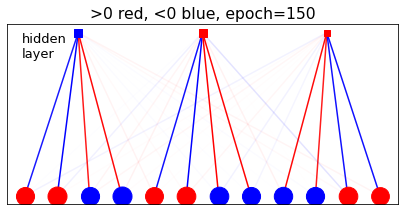

In [33]:
plotgraph(150, w_l, a_l, b_l)

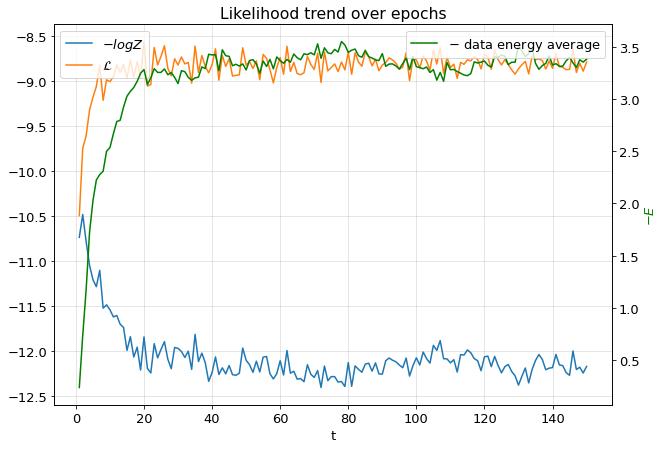

In [37]:
# plot log likelihood during training

logZfunc_ = (-1)*np.array(logZfunc)

fig, ax = plt.subplots(figsize=(10,7))
ax.grid(alpha=0.4)

eps = np.linspace(1, len(logL), len(logL))

ax1 = ax.twinx()
ax1.plot(eps, (-1)*np.array(dataenergies), label = '$-$ data energy average', color = 'green')
ax.plot(eps, logZfunc_, label = '$-logZ$')
ax.plot(eps, logL, label = '$\\mathcal{L}$')
ax.set_xlabel('t')
ax.set_title('Likelihood trend over epochs')
ax.legend(loc='upper left')
#ax.set_ylim(-12.7,-9.5)
# ax1.set_ylim(-0.3,0.7)
ax1.legend(loc='upper right')
ax1.set_ylabel('$-E$', color = 'green')

plt.show()

### 3. For M=3, plot the likelihood as a function of 't', comparing the two contrastive divergence cases ($n=1$ and $n=5$). Then, for $n=1$, plot the likelihood as a function of 't', comparing the two cases with different $M$.

### 4. From the weights learned by the RBM, guess the structure of the data.

### 5. Try RBMs with different numbers of hidden units: $M=1,2,3,4,5,6.$